# Automatic lightfield completion

Train a VAE on the images of a cross-shaped lightfield array to predict the diagonals

In [8]:
# Imports and data loading

import os
from dataloaders import hci4d
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import lightfield_vae as vae

DATA_ROOT = os.path.join('data', 'SyntheticLightfieldData')
train_loader = hci4d.HCI4D(os.path.join(DATA_ROOT, 'training'))
test_loader = hci4d.HCI4D(os.path.join(DATA_ROOT, 'test'))


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


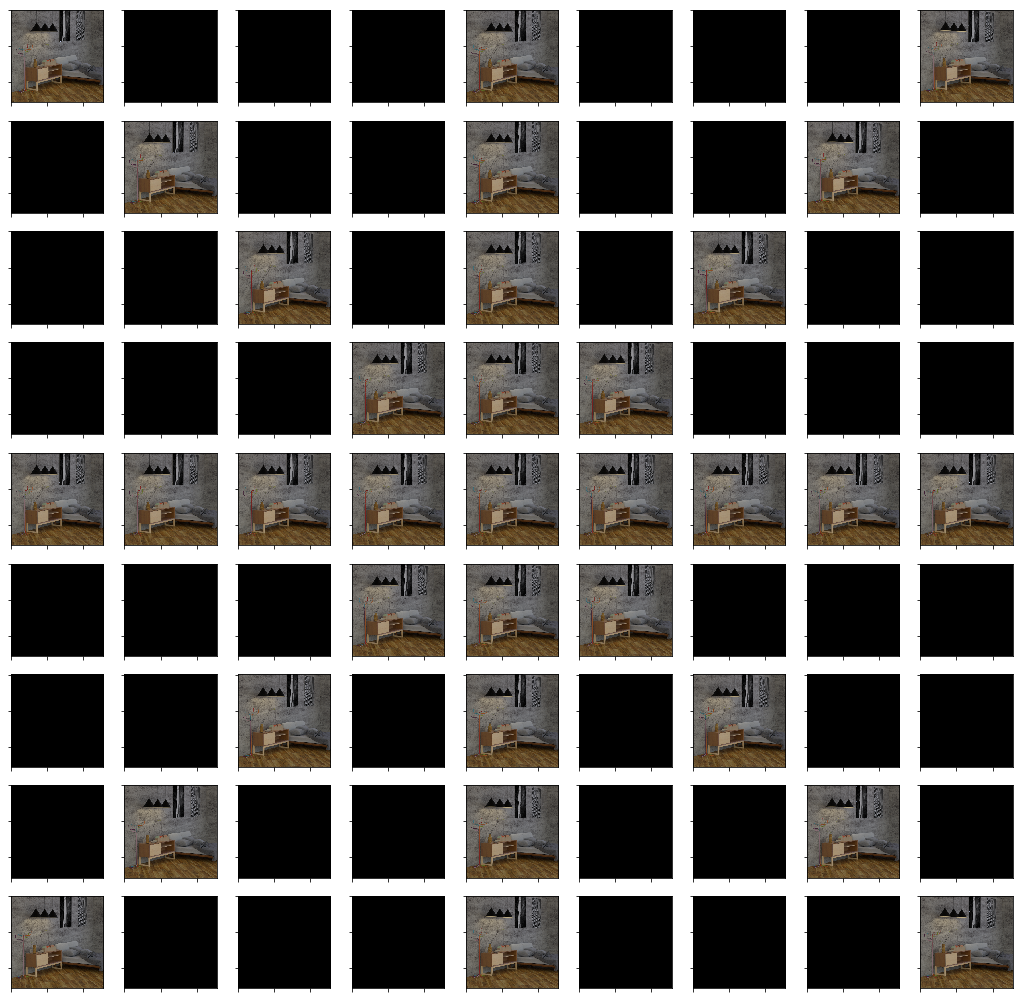

In [9]:
# Show an example image from the test set
vae.show_scene(test_loader.load_scene(0))

In [11]:
# Training and testing routines similar to the PyTorch implementation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vae.VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch, log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, batch_size=128):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))